# 对数据做初步分析

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import random

In [2]:
train_data = pd.read_csv('../data/zhengqi_train.txt', sep = '\t')
test_data = pd.read_csv('../data/zhengqi_test.txt', sep = '\t')

## 查看数据形式

In [3]:
train_data.head(5)

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V29,V30,V31,V32,V33,V34,V35,V36,V37,target
0,0.566,0.016,-0.143,0.407,0.452,-0.901,-1.812,-2.360,-0.436,-2.114,...,0.136,0.109,-0.615,0.327,-4.627,-4.789,-5.101,-2.608,-3.508,0.175
1,0.968,0.437,0.066,0.566,0.194,-0.893,-1.566,-2.360,0.332,-2.114,...,-0.128,0.124,0.032,0.600,-0.843,0.160,0.364,-0.335,-0.730,0.676
2,1.013,0.568,0.235,0.370,0.112,-0.797,-1.367,-2.360,0.396,-2.114,...,-0.009,0.361,0.277,-0.116,-0.843,0.160,0.364,0.765,-0.589,0.633
3,0.733,0.368,0.283,0.165,0.599,-0.679,-1.200,-2.086,0.403,-2.114,...,0.015,0.417,0.279,0.603,-0.843,-0.065,0.364,0.333,-0.112,0.206
4,0.684,0.638,0.260,0.209,0.337,-0.454,-1.073,-2.086,0.314,-2.114,...,0.183,1.078,0.328,0.418,-0.843,-0.215,0.364,-0.280,-0.028,0.384


In [4]:
test_data.head(5)

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37
0,0.368,0.380,-0.225,-0.049,0.379,0.092,0.550,0.551,0.244,0.904,...,-0.449,0.047,0.057,-0.042,0.847,0.534,-0.009,-0.190,-0.567,0.388
1,0.148,0.489,-0.247,-0.049,0.122,-0.201,0.487,0.493,-0.127,0.904,...,-0.443,0.047,0.560,0.176,0.551,0.046,-0.220,0.008,-0.294,0.104
2,-0.166,-0.062,-0.311,0.046,-0.055,0.063,0.485,0.493,-0.227,0.904,...,-0.458,-0.398,0.101,0.199,0.634,0.017,-0.234,0.008,0.373,0.569
3,0.102,0.294,-0.259,0.051,-0.183,0.148,0.474,0.504,0.010,0.904,...,-0.456,-0.398,1.007,0.137,1.042,-0.040,-0.290,0.008,-0.666,0.391
4,0.300,0.428,0.208,0.051,-0.033,0.116,0.408,0.497,0.155,0.904,...,-0.458,-0.776,0.291,0.370,0.181,-0.040,-0.290,0.008,-0.140,-0.497


## 对比训练数据特征分布与预测数据特征分布，筛选出需要使用的特征

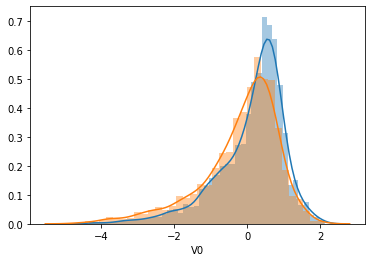

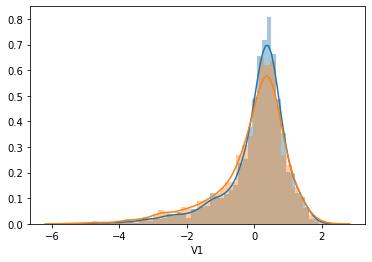

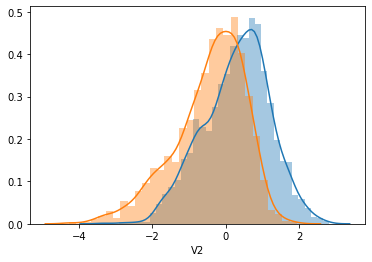

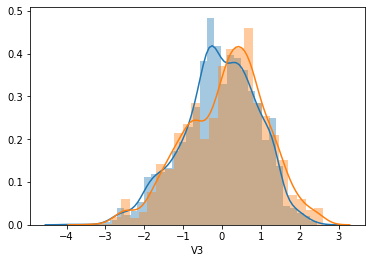

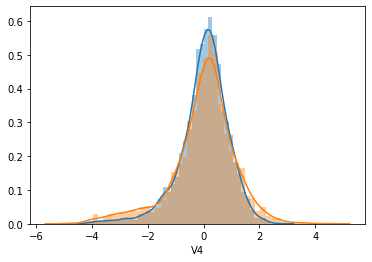

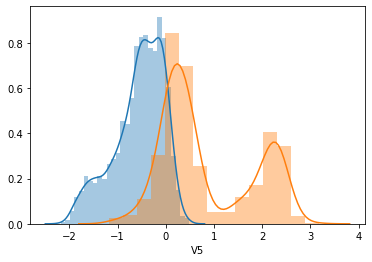

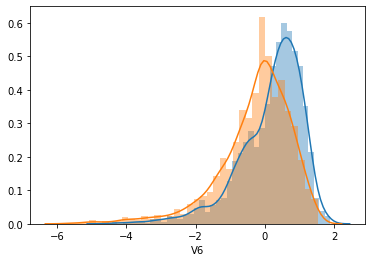

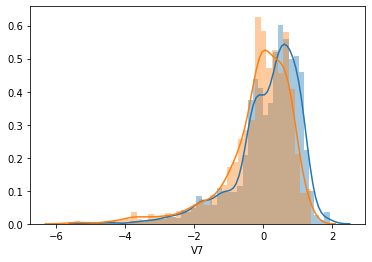

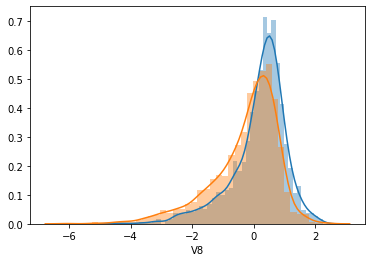

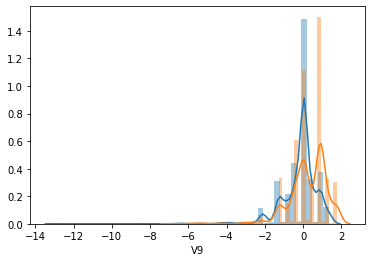

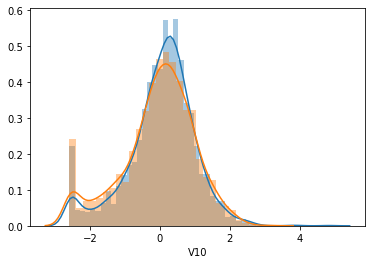

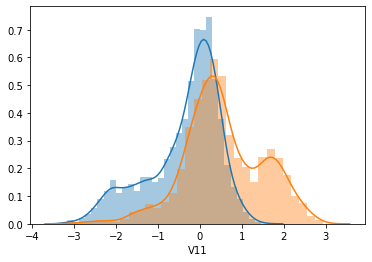

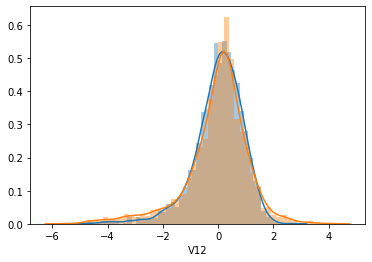

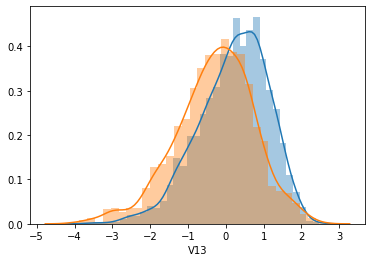

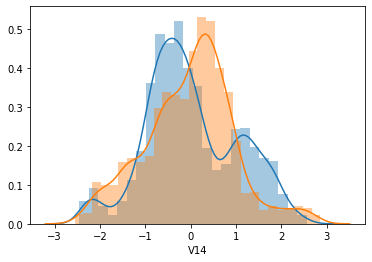

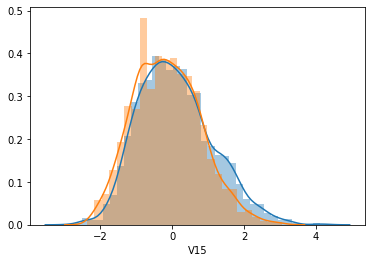

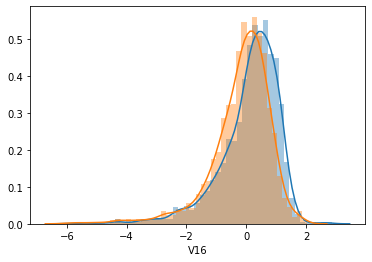

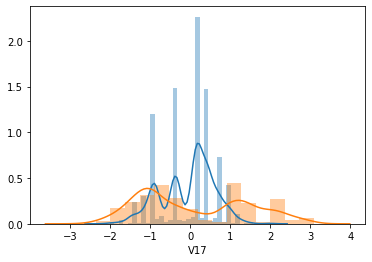

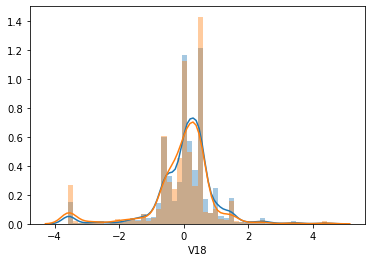

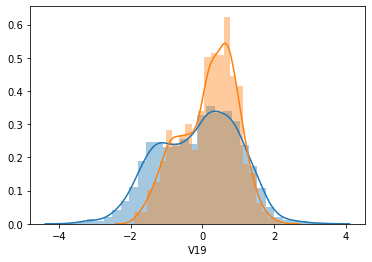

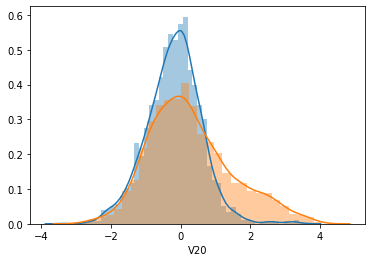

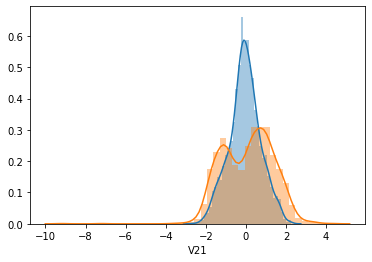

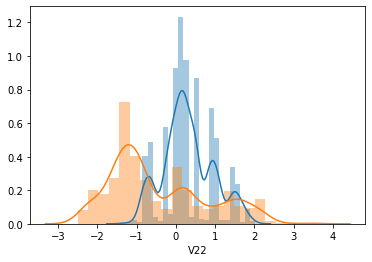

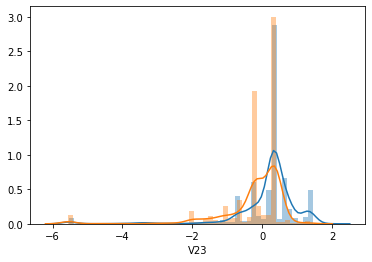

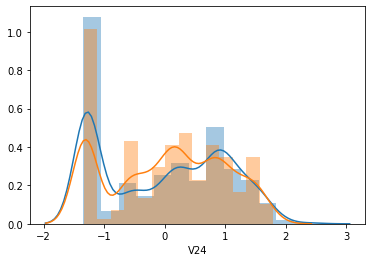

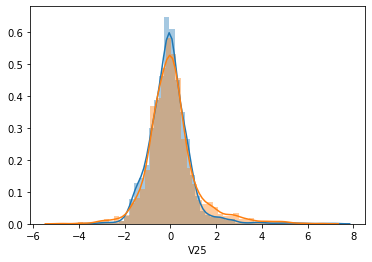

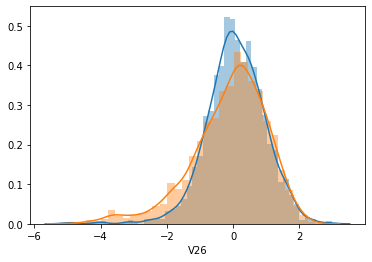

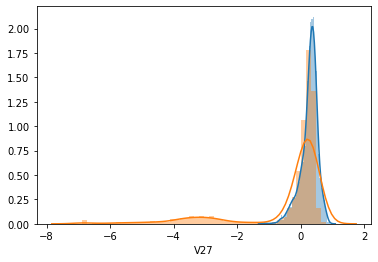

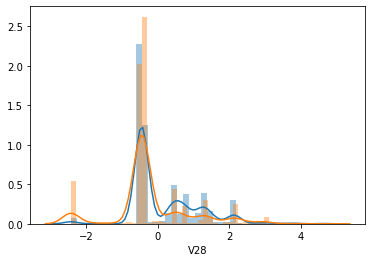

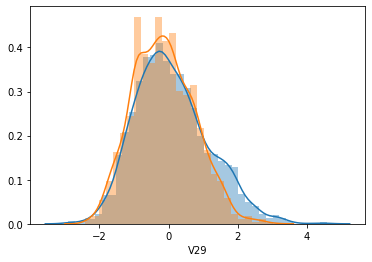

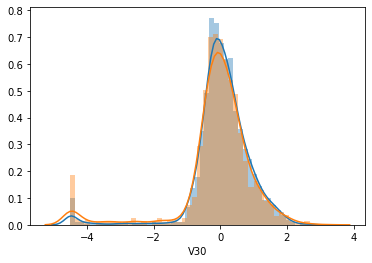

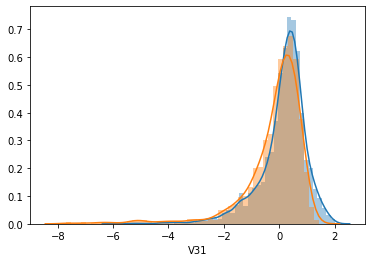

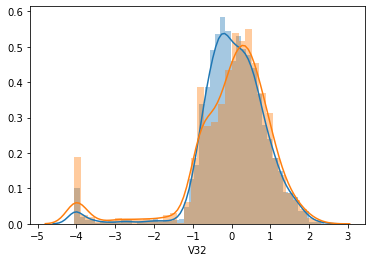

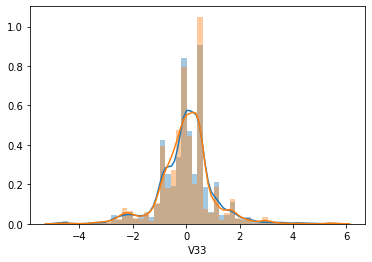

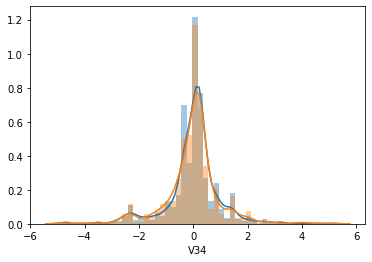

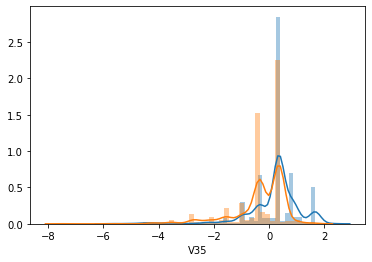

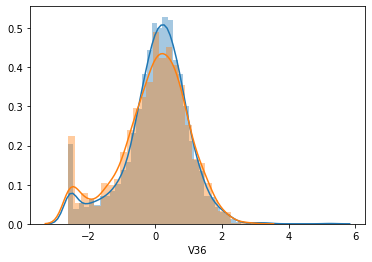

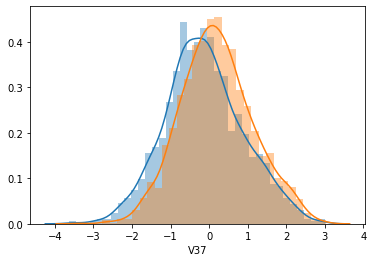

In [5]:
for col in test_data.columns:
    seaborn.distplot(train_data[col])
    seaborn.distplot(test_data[col])
    plt.show()

### 通过对比，发现'V5','V9','V11', 'V14', 'V17', 'V19', 'V21', 'V22'六个特征在训练集和测试集的分布相差较大，说明这些特征与结果的相关性较差，应该剔除。

## 删除'V5','V9','V11', 'V14', 'V17', 'V19', 'V21', 'V22'六列数据

In [6]:
train_data.drop(['V5','V9','V11', 'V14', 'V17', 'V19', 'V21', 'V22'], axis = 1, inplace = True)
test_data.drop(['V5','V9','V11', 'V14', 'V17', 'V19', 'V21', 'V22'], axis = 1, inplace = True)

In [7]:
#从训练数据中取10%作为验证集
data = np.array(train_data, dtype = 'float32')
test_data = np.array(test_data, dtype = 'float32')
split = int(0.9 * data.shape[0])
train_data = data[:split, :]
val_data = data[split:, :]
train_x = train_data[:, :-1]
train_y = train_data[:, -1]
val_x = val_data[:, :-1]
val_y = val_data[:, -1]

In [8]:
#对特征做归一化
total_data = np.vstack((data[:,:-1], test_data))
minimum = total_data.min(0)
maximum = total_data.max(0)
train_x = (train_x - minimum) / (maximum - minimum)
val_x = (val_x - minimum) / (maximum - minimum)
test_data = (test_data - minimum) / (maximum - minimum)

In [9]:
#定义网络结构，使用四层全连接网络
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.utils.data as tud

SEED = 1234
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

class Net(nn.Module):
    def __init__(self, dropout = 0.2):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(30, 50)
        self.layer2 = nn.Linear(50, 50)
        self.layer3 = nn.Linear(50, 30)
        self.layer4 = nn.Linear(30, 1)
        self.dropout = nn.Dropout(dropout)
        self._init_weight()
        
    def _init_weight(self):
        init.xavier_uniform_(self.layer1.weight)
        init.xavier_uniform_(self.layer2.weight)
        init.xavier_uniform_(self.layer3.weight)
        init.xavier_uniform_(self.layer4.weight)
        init.zeros_(self.layer1.bias)
        init.zeros_(self.layer2.bias)
        init.zeros_(self.layer3.bias)
        init.zeros_(self.layer4.bias)
        
    def forward(self, inputs):
        outputs = self.layer1(inputs)
        outputs = self.dropout(outputs)
        #outputs = torch.tanh(outputs)
        outputs = F.relu(outputs)
        outputs = self.layer2(outputs)
        #outputs = torch.tanh(outputs)
        outputs = F.relu(outputs)
        outputs = self.layer3(outputs)
        #outputs = torch.tanh(outputs)
        outputs = F.relu(outputs)
        outputs = self.layer4(outputs)
        return outputs

In [10]:
train_x = torch.from_numpy(train_x)
train_y = torch.from_numpy(train_y)
val_x = torch.from_numpy(val_x)
val_y = torch.from_numpy(val_y)

In [11]:
model = Net()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.8)
norm_rate = 0.1

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
train_x = train_x.to(device)
train_y = train_y.to(device)
val_x = val_x.to(device)
val_y = val_y.to(device)

In [13]:
def evaluate(model, val_data):
    with torch.no_grad():
        model.eval()
        pred = model(val_data)
        return pred.squeeze()

## 训练

In [14]:
best_val_loss = float('inf')
for epoch in range(3000):
    model.train()
    #print(y.shape)
    model.zero_grad()
    predict = model(train_x).squeeze()
    loss = loss_fn(predict, train_y)
    loss = loss + norm_rate * (torch.norm(model.layer1.weight, 2) + torch.norm(model.layer2.weight, 2) + \
    torch.norm(model.layer3.weight, 2) + torch.norm(model.layer4.weight, 2))
    loss.backward()
    optimizer.step()
    scheduler.step()
    print('epoch:{}, loss:{}'.format(epoch, loss.item()))
    
    val_pred = evaluate(model, val_x)
    val_loss = loss_fn(val_y, val_pred).item()

    #print('-'*50)
    print('validation loss:', val_loss)
    print('-'*50)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')

epoch:0, loss:3.5377554893493652
validation loss: 1.3427892923355103
--------------------------------------------------
epoch:1, loss:3.126810073852539
validation loss: 1.3047785758972168
--------------------------------------------------
epoch:2, loss:3.0270791053771973
validation loss: 1.1794116497039795
--------------------------------------------------
epoch:3, loss:2.828667402267456
validation loss: 1.1555625200271606
--------------------------------------------------
epoch:4, loss:2.721574306488037
validation loss: 1.1917815208435059
--------------------------------------------------
epoch:5, loss:2.689497709274292
validation loss: 1.1775553226470947
--------------------------------------------------
epoch:6, loss:2.6289291381835938
validation loss: 1.137798547744751
--------------------------------------------------
epoch:7, loss:2.554004669189453
validation loss: 1.121442437171936
--------------------------------------------------
epoch:8, loss:2.4902753829956055
validation los

epoch:120, loss:1.0876253843307495
validation loss: 0.3307098150253296
--------------------------------------------------
epoch:121, loss:1.0883092880249023
validation loss: 0.33278074860572815
--------------------------------------------------
epoch:122, loss:1.095055341720581
validation loss: 0.3331950902938843
--------------------------------------------------
epoch:123, loss:1.086511254310608
validation loss: 0.33212941884994507
--------------------------------------------------
epoch:124, loss:1.0807157754898071
validation loss: 0.32989075779914856
--------------------------------------------------
epoch:125, loss:1.084370732307434
validation loss: 0.3282179832458496
--------------------------------------------------
epoch:126, loss:1.0812170505523682
validation loss: 0.3285824954509735
--------------------------------------------------
epoch:127, loss:1.083324909210205
validation loss: 0.32957154512405396
--------------------------------------------------
epoch:128, loss:1.076951

epoch:192, loss:1.0509902238845825
validation loss: 0.3251119554042816
--------------------------------------------------
epoch:193, loss:1.0540342330932617
validation loss: 0.3254076838493347
--------------------------------------------------
epoch:194, loss:1.0490132570266724
validation loss: 0.32560527324676514
--------------------------------------------------
epoch:195, loss:1.0471495389938354
validation loss: 0.3258351981639862
--------------------------------------------------
epoch:196, loss:1.0523767471313477
validation loss: 0.3260830342769623
--------------------------------------------------
epoch:197, loss:1.04282546043396
validation loss: 0.3261989653110504
--------------------------------------------------
epoch:198, loss:1.0484410524368286
validation loss: 0.3258166015148163
--------------------------------------------------
epoch:199, loss:1.0420973300933838
validation loss: 0.32548168301582336
--------------------------------------------------
epoch:200, loss:1.050196

epoch:266, loss:1.0353999137878418
validation loss: 0.3245430886745453
--------------------------------------------------
epoch:267, loss:1.038083791732788
validation loss: 0.32465729117393494
--------------------------------------------------
epoch:268, loss:1.0420855283737183
validation loss: 0.3247697353363037
--------------------------------------------------
epoch:269, loss:1.041456699371338
validation loss: 0.32486093044281006
--------------------------------------------------
epoch:270, loss:1.0378400087356567
validation loss: 0.32488569617271423
--------------------------------------------------
epoch:271, loss:1.0381580591201782
validation loss: 0.32493656873703003
--------------------------------------------------
epoch:272, loss:1.0468887090682983
validation loss: 0.32496318221092224
--------------------------------------------------
epoch:273, loss:1.040949821472168
validation loss: 0.32493215799331665
--------------------------------------------------
epoch:274, loss:1.038

epoch:341, loss:1.040079116821289
validation loss: 0.3245648443698883
--------------------------------------------------
epoch:342, loss:1.042115330696106
validation loss: 0.32457900047302246
--------------------------------------------------
epoch:343, loss:1.0353180170059204
validation loss: 0.3246011734008789
--------------------------------------------------
epoch:344, loss:1.038307785987854
validation loss: 0.32461977005004883
--------------------------------------------------
epoch:345, loss:1.0354180335998535
validation loss: 0.3246355950832367
--------------------------------------------------
epoch:346, loss:1.039749026298523
validation loss: 0.32465219497680664
--------------------------------------------------
epoch:347, loss:1.0394506454467773
validation loss: 0.3246592581272125
--------------------------------------------------
epoch:348, loss:1.0421980619430542
validation loss: 0.3246614634990692
--------------------------------------------------
epoch:349, loss:1.0371015

epoch:415, loss:1.0365946292877197
validation loss: 0.32477542757987976
--------------------------------------------------
epoch:416, loss:1.036759853363037
validation loss: 0.32477521896362305
--------------------------------------------------
epoch:417, loss:1.036957025527954
validation loss: 0.32477521896362305
--------------------------------------------------
epoch:418, loss:1.0421340465545654
validation loss: 0.3247738182544708
--------------------------------------------------
epoch:419, loss:1.0381219387054443
validation loss: 0.3247694671154022
--------------------------------------------------
epoch:420, loss:1.0396982431411743
validation loss: 0.32476648688316345
--------------------------------------------------
epoch:421, loss:1.031975269317627
validation loss: 0.32476237416267395
--------------------------------------------------
epoch:422, loss:1.0340853929519653
validation loss: 0.3247600495815277
--------------------------------------------------
epoch:423, loss:1.0388

validation loss: 0.3246568739414215
--------------------------------------------------
epoch:492, loss:1.0378148555755615
validation loss: 0.32465660572052
--------------------------------------------------
epoch:493, loss:1.0339239835739136
validation loss: 0.3246559202671051
--------------------------------------------------
epoch:494, loss:1.0386366844177246
validation loss: 0.32465556263923645
--------------------------------------------------
epoch:495, loss:1.0413508415222168
validation loss: 0.3246549367904663
--------------------------------------------------
epoch:496, loss:1.0361279249191284
validation loss: 0.324654221534729
--------------------------------------------------
epoch:497, loss:1.0369607210159302
validation loss: 0.32465317845344543
--------------------------------------------------
epoch:498, loss:1.0401663780212402
validation loss: 0.32465192675590515
--------------------------------------------------
epoch:499, loss:1.0346291065216064
validation loss: 0.32465

validation loss: 0.3246353268623352
--------------------------------------------------
epoch:566, loss:1.0368168354034424
validation loss: 0.3246350884437561
--------------------------------------------------
epoch:567, loss:1.0386934280395508
validation loss: 0.32463476061820984
--------------------------------------------------
epoch:568, loss:1.036473035812378
validation loss: 0.32463446259498596
--------------------------------------------------
epoch:569, loss:1.033639669418335
validation loss: 0.3246340751647949
--------------------------------------------------
epoch:570, loss:1.0340222120285034
validation loss: 0.32463374733924866
--------------------------------------------------
epoch:571, loss:1.0402147769927979
validation loss: 0.3246334493160248
--------------------------------------------------
epoch:572, loss:1.0392323732376099
validation loss: 0.3246331214904785
--------------------------------------------------
epoch:573, loss:1.0354276895523071
validation loss: 0.3246

epoch:640, loss:1.0352883338928223
validation loss: 0.324630469083786
--------------------------------------------------
epoch:641, loss:1.0351845026016235
validation loss: 0.3246304392814636
--------------------------------------------------
epoch:642, loss:1.030703067779541
validation loss: 0.32463037967681885
--------------------------------------------------
epoch:643, loss:1.0381087064743042
validation loss: 0.3246303200721741
--------------------------------------------------
epoch:644, loss:1.0371968746185303
validation loss: 0.3246302604675293
--------------------------------------------------
epoch:645, loss:1.036669373512268
validation loss: 0.3246302306652069
--------------------------------------------------
epoch:646, loss:1.0374804735183716
validation loss: 0.32463017106056213
--------------------------------------------------
epoch:647, loss:1.03871488571167
validation loss: 0.32463011145591736
--------------------------------------------------
epoch:648, loss:1.03754794

validation loss: 0.3246290981769562
--------------------------------------------------
epoch:715, loss:1.0371763706207275
validation loss: 0.3246290981769562
--------------------------------------------------
epoch:716, loss:1.0408973693847656
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:717, loss:1.0377986431121826
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:718, loss:1.034928560256958
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:719, loss:1.0302904844284058
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:720, loss:1.0342497825622559
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:721, loss:1.0383251905441284
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:722, loss:1.0369837284088135
validation loss: 0.324629

epoch:789, loss:1.0342520475387573
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:790, loss:1.0376605987548828
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:791, loss:1.0379786491394043
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:792, loss:1.03485107421875
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:793, loss:1.0360091924667358
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:794, loss:1.041497826576233
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:795, loss:1.0366429090499878
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:796, loss:1.0397722721099854
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:797, loss:1.038663029

epoch:864, loss:1.0401455163955688
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:865, loss:1.041886568069458
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:866, loss:1.0324103832244873
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:867, loss:1.0344483852386475
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:868, loss:1.0377403497695923
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:869, loss:1.03792142868042
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:870, loss:1.0372883081436157
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:871, loss:1.0348807573318481
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:872, loss:1.039175271

validation loss: 0.3246290683746338
--------------------------------------------------
epoch:939, loss:1.042802095413208
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:940, loss:1.0338228940963745
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:941, loss:1.0376578569412231
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:942, loss:1.0381953716278076
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:943, loss:1.0339691638946533
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:944, loss:1.0427613258361816
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:945, loss:1.036621332168579
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:946, loss:1.0460922718048096
validation loss: 0.3246290

validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1062, loss:1.041142225265503
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1063, loss:1.0306540727615356
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1064, loss:1.04297935962677
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1065, loss:1.0370489358901978
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1066, loss:1.0365533828735352
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1067, loss:1.0416264533996582
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1068, loss:1.034746766090393
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1069, loss:1.0368461608886719
validation loss: 0.3

epoch:1135, loss:1.034590482711792
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1136, loss:1.0350359678268433
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1137, loss:1.0401395559310913
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1138, loss:1.0377415418624878
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1139, loss:1.0352180004119873
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1140, loss:1.0397748947143555
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1141, loss:1.0318176746368408
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1142, loss:1.0378401279449463
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1143, loss:

validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1209, loss:1.0363240242004395
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1210, loss:1.0369551181793213
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1211, loss:1.039852499961853
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1212, loss:1.0336482524871826
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1213, loss:1.0408231019973755
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1214, loss:1.0362130403518677
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1215, loss:1.0362064838409424
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1216, loss:1.0396349430084229
validation loss: 

validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1282, loss:1.0393133163452148
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1283, loss:1.029733419418335
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1284, loss:1.0312950611114502
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1285, loss:1.0376393795013428
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1286, loss:1.0364702939987183
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1287, loss:1.0445408821105957
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1288, loss:1.0411747694015503
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1289, loss:1.0397206544876099
validation loss: 

epoch:1355, loss:1.036859154701233
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1356, loss:1.0380597114562988
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1357, loss:1.038927674293518
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1358, loss:1.0403379201889038
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1359, loss:1.0406372547149658
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1360, loss:1.0335516929626465
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1361, loss:1.043793797492981
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1362, loss:1.0408141613006592
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1363, loss:1.

validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1430, loss:1.033621072769165
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1431, loss:1.0399630069732666
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1432, loss:1.0326557159423828
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1433, loss:1.0340876579284668
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1434, loss:1.0342563390731812
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1435, loss:1.038390874862671
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1436, loss:1.0368680953979492
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1437, loss:1.0371838808059692
validation loss: 0

epoch:1503, loss:1.039124846458435
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1504, loss:1.0392619371414185
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1505, loss:1.0416820049285889
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1506, loss:1.038177251815796
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1507, loss:1.03944730758667
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1508, loss:1.0302096605300903
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1509, loss:1.0382390022277832
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1510, loss:1.041414499282837
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1511, loss:1.03

epoch:1576, loss:1.0368746519088745
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1577, loss:1.0389933586120605
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1578, loss:1.035653829574585
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1579, loss:1.0320934057235718
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1580, loss:1.0373488664627075
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1581, loss:1.0393766164779663
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1582, loss:1.033264398574829
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1583, loss:1.0357468128204346
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1584, loss:1

validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1650, loss:1.0351940393447876
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1651, loss:1.0365114212036133
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1652, loss:1.0283150672912598
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1653, loss:1.0324394702911377
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1654, loss:1.0381942987442017
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1655, loss:1.0341875553131104
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1656, loss:1.0338634252548218
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1657, loss:1.0404996871948242
validation loss:

validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1723, loss:1.0369263887405396
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1724, loss:1.0369688272476196
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1725, loss:1.031008005142212
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1726, loss:1.0376731157302856
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1727, loss:1.0377260446548462
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1728, loss:1.036104440689087
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1729, loss:1.035647988319397
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1730, loss:1.033164143562317
validation loss: 0.3

validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1797, loss:1.0359259843826294
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1798, loss:1.0398834943771362
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1799, loss:1.0367929935455322
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1800, loss:1.0348401069641113
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1801, loss:1.042581558227539
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1802, loss:1.0322186946868896
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1803, loss:1.035037875175476
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1804, loss:1.0350191593170166
validation loss: 0

validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1870, loss:1.036317229270935
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1871, loss:1.0380107164382935
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1872, loss:1.0356725454330444
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1873, loss:1.0423083305358887
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1874, loss:1.0364232063293457
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1875, loss:1.0376324653625488
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1876, loss:1.0377269983291626
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1877, loss:1.0359344482421875
validation loss: 

validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1943, loss:1.0397112369537354
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1944, loss:1.0410284996032715
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1945, loss:1.036806583404541
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1946, loss:1.0362193584442139
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1947, loss:1.0428920984268188
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1948, loss:1.0345585346221924
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1949, loss:1.0372228622436523
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:1950, loss:1.0373756885528564
validation loss: 

epoch:2016, loss:1.034623384475708
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2017, loss:1.03597891330719
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2018, loss:1.0350124835968018
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2019, loss:1.035020351409912
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2020, loss:1.0424721240997314
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2021, loss:1.0337028503417969
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2022, loss:1.0394396781921387
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2023, loss:1.0378525257110596
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2024, loss:1.0

validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2090, loss:1.0391141176223755
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2091, loss:1.0352096557617188
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2092, loss:1.0360150337219238
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2093, loss:1.0400185585021973
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2094, loss:1.0382122993469238
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2095, loss:1.0360597372055054
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2096, loss:1.038124442100525
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2097, loss:1.0369787216186523
validation loss: 

epoch:2163, loss:1.0374670028686523
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2164, loss:1.0348200798034668
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2165, loss:1.0409563779830933
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2166, loss:1.034286618232727
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2167, loss:1.038813591003418
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2168, loss:1.0436370372772217
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2169, loss:1.0381801128387451
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2170, loss:1.037710189819336
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2171, loss:1.

validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2237, loss:1.030802845954895
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2238, loss:1.0364429950714111
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2239, loss:1.0400973558425903
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2240, loss:1.0426573753356934
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2241, loss:1.0442534685134888
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2242, loss:1.0387192964553833
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2243, loss:1.0356454849243164
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2244, loss:1.0376158952713013
validation loss: 

epoch:2310, loss:1.0383501052856445
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2311, loss:1.0385711193084717
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2312, loss:1.037209391593933
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2313, loss:1.0367915630340576
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2314, loss:1.0380884408950806
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2315, loss:1.038051962852478
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2316, loss:1.0388058423995972
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2317, loss:1.0350970029830933
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2318, loss:1

epoch:2384, loss:1.041996717453003
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2385, loss:1.0387003421783447
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2386, loss:1.0370806455612183
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2387, loss:1.0390141010284424
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2388, loss:1.0417958498001099
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2389, loss:1.0403392314910889
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2390, loss:1.035951852798462
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2391, loss:1.0385615825653076
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2392, loss:1

validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2459, loss:1.0389484167099
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2460, loss:1.0374348163604736
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2461, loss:1.0406568050384521
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2462, loss:1.0347455739974976
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2463, loss:1.036537766456604
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2464, loss:1.0341204404830933
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2465, loss:1.0355758666992188
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2466, loss:1.0419325828552246
validation loss: 0.3

validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2532, loss:1.0365169048309326
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2533, loss:1.0358551740646362
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2534, loss:1.0347001552581787
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2535, loss:1.0334773063659668
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2536, loss:1.039556622505188
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2537, loss:1.0379788875579834
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2538, loss:1.0396244525909424
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2539, loss:1.033957839012146
validation loss: 0

validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2605, loss:1.0355792045593262
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2606, loss:1.0385768413543701
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2607, loss:1.0401780605316162
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2608, loss:1.039710283279419
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2609, loss:1.0364350080490112
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2610, loss:1.0356276035308838
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2611, loss:1.045201301574707
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2612, loss:1.0407438278198242
validation loss: 0

validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2679, loss:1.0352181196212769
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2680, loss:1.0389896631240845
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2681, loss:1.03218674659729
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2682, loss:1.040501356124878
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2683, loss:1.0397192239761353
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2684, loss:1.0396772623062134
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2685, loss:1.0379785299301147
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2686, loss:1.039216160774231
validation loss: 0.3

epoch:2752, loss:1.0379983186721802
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2753, loss:1.0382858514785767
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2754, loss:1.0369987487792969
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2755, loss:1.0360589027404785
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2756, loss:1.038345217704773
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2757, loss:1.0412417650222778
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2758, loss:1.032854437828064
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2759, loss:1.031266450881958
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2760, loss:1.

epoch:2826, loss:1.0324095487594604
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2827, loss:1.045234203338623
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2828, loss:1.0380208492279053
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2829, loss:1.034685492515564
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2830, loss:1.0371158123016357
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2831, loss:1.0349160432815552
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2832, loss:1.034209132194519
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2833, loss:1.0306494235992432
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2834, loss:1.

epoch:2900, loss:1.0391433238983154
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2901, loss:1.0333894491195679
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2902, loss:1.0341285467147827
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2903, loss:1.0408480167388916
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2904, loss:1.0399202108383179
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2905, loss:1.0368554592132568
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2906, loss:1.036576747894287
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2907, loss:1.0355916023254395
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2908, loss:

validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2975, loss:1.0361453294754028
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2976, loss:1.034973382949829
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2977, loss:1.0415865182876587
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2978, loss:1.0389100313186646
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2979, loss:1.0373375415802002
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2980, loss:1.0374324321746826
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2981, loss:1.0413951873779297
validation loss: 0.3246290683746338
--------------------------------------------------
epoch:2982, loss:1.0424405336380005
validation loss: 

## 预测

In [15]:
test_x = torch.from_numpy(test_data).to(device)
best_model = Net()
best_model = best_model.to(device)
best_model.load_state_dict(torch.load('best_model.pt'))
test_result = evaluate(best_model, test_x)
result = test_result.cpu().numpy()
with open('result_4.txt', 'w') as f:
    for i in result:
        f.write(str(i) + '\n')

## 线上评测结果：0.1823